In [2]:
# 1. Java (required by Spark) and unzip if needed
!apt-get update -qq
!apt-get install -y openjdk-11-jdk-headless -qq

# 2. Install PySpark and kaggle CLI (optional)
!pip install -q pyspark==3.5.1 kaggle


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


**Start SparkSession **

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Colab_Retail_Analysis") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

print("Spark version:", spark.version)


Spark version: 3.5.1


**Load the Dataset**

In [15]:
data_path = "/content/drive/MyDrive/6-weeks Internship/Dataset/P-1 new_retail_data.csv"

df = spark.read.option("header", True).option("inferSchema", True).csv(data_path)
df.printSchema()
df.show(5)


root
 |-- Transaction_ID: double (nullable = true)
 |-- Customer_ID: double (nullable = true)
 |-- Name: string (nullable = true)
 |-- Email: string (nullable = true)
 |-- Phone: double (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- Customer_Segment: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- Month: string (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Total_Purchases: double (nullable = true)
 |-- Amount: double (nullable = true)
 |-- Total_Amount: double (nullable = true)
 |-- Product_Category: string (nullable = true)
 |-- Product_Brand: string (nullable = true)
 |-- Product_Type: string (nullable = true)
 |-- Feedback: string (nullable =

**Data Cleaning**

In [18]:
from pyspark.sql.functions import col

df_clean = df.filter(col("Customer_ID").isNotNull()) \
             .filter(col("Amount").isNotNull()) \
             .filter(col("Amount") > 0) \
             .filter(col("Product_Category").isNotNull())

print("✅ Cleaned Data Count:", df_clean.count())


✅ Cleaned Data Count: 301062


**Feature Engineering**

In [19]:
from pyspark.sql.functions import hour, dayofweek, month, year

df_feat = df_clean.withColumn("hour", hour(col("Time"))) \
                  .withColumn("day_of_week", dayofweek(col("Time"))) \
                  .withColumn("month_num", month(col("Time"))) \
                  .withColumn("year_num", year(col("Time")))

df_feat.select("Date", "hour", "day_of_week", "month_num").show(5)


+----------+----+-----------+---------+
|      Date|hour|day_of_week|month_num|
+----------+----+-----------+---------+
| 9/18/2023|  22|          3|       10|
|12/31/2023|   8|          3|       10|
| 4/26/2023|   4|          3|       10|
|  5/8/2023|  14|          3|       10|
| 1/10/2024|  16|          3|       10|
+----------+----+-----------+---------+
only showing top 5 rows



**Exploratory Data Analysis (EDA)**

In [20]:
#Customer Spending Patterns

from pyspark.sql.functions import sum as spark_sum, avg as spark_avg, count as spark_count

cust_spend = df_feat.groupBy("Customer_ID", "Gender", "Customer_Segment").agg(
    spark_count("Transaction_ID").alias("num_transactions"),
    spark_sum("Amount").alias("total_spent"),
    spark_avg("Amount").alias("avg_spent")
).orderBy(col("total_spent").desc())

cust_spend.show(10)


+-----------+------+----------------+----------------+------------------+------------------+
|Customer_ID|Gender|Customer_Segment|num_transactions|       total_spent|         avg_spent|
+-----------+------+----------------+----------------+------------------+------------------+
|    48453.0|  Male|         Regular|               8|     2781.97273131|   347.74659141375|
|    45975.0|  Male|         Regular|               9|     2567.71545463| 285.3017171811111|
|    51763.0|  Male|         Regular|               7|2333.8561028999998|333.40801469999997|
|    23482.0|  Male|         Regular|               8|2266.2004362400003|283.27505453000003|
|    67125.0|  Male|         Regular|               7|     2262.05367078| 323.1505243971429|
|    72561.0|  Male|         Regular|               6|      2217.9875255|369.66458758333334|
|    81423.0|  Male|         Regular|               6|      2181.2304933|      363.53841555|
|    62540.0|  Male|         Regular|               8|2138.75605689999

In [21]:
#Revenue by Product Category

prod_rev = df_feat.groupBy("Product_Category").agg(
    spark_sum("Amount").alias("total_revenue"),
    spark_avg("Ratings").alias("avg_rating"),
    spark_count("Transaction_ID").alias("num_sales")
).orderBy(col("total_revenue").desc())

prod_rev.show(10, truncate=False)


+----------------+--------------------+------------------+---------+
|Product_Category|total_revenue       |avg_rating        |num_sales|
+----------------+--------------------+------------------+---------+
|Electronics     |1.814107962594283E7 |3.2686699632306326|70944    |
|Grocery         |1.700902338838079E7 |3.181479702137881 |66553    |
|Clothing        |1.3924622830138922E7|3.1045574443141852|54575    |
|Books           |1.3905601329748966E7|3.112542671511948 |54459    |
|Home Decor      |1.383929403814276E7 |3.109557453559372 |54199    |
+----------------+--------------------+------------------+---------+



In [22]:
#Payment Method Analysis

pay_method = df_feat.groupBy("Payment_Method").agg(
    spark_count("Transaction_ID").alias("txn_count"),
    spark_sum("Amount").alias("total_spent")
).orderBy(col("txn_count").desc())

pay_method.show()


+--------------+---------+--------------------+
|Payment_Method|txn_count|         total_spent|
+--------------+---------+--------------------+
|   Credit Card|    89722|2.2946673692686725E7|
|    Debit Card|    76479|1.9534409574444026E7|
|          Cash|    73511|1.8756638616076276E7|
|        PayPal|    60721|1.5510453120296553E7|
|          NULL|      297|   71446.20885060003|
+--------------+---------+--------------------+



In [23]:
#Age & Gender Impact on Spending

age_gender = df_feat.groupBy("Gender").agg(
    spark_avg("Age").alias("avg_age"),
    spark_sum("Amount").alias("total_spent")
)
age_gender.show()


+------+------------------+--------------------+
|Gender|           avg_age|         total_spent|
+------+------------------+--------------------+
|  NULL|37.078864353312305|   82361.97585481996|
|Female|36.010275087311854|2.9042996872357994E7|
|  Male| 35.15363378081209|4.7694262364141285E7|
+------+------------------+--------------------+



In [24]:
#Temporal Trends (Hourly, Monthly Revenue)

hourly_sales = df_feat.groupBy("hour").agg(
    spark_sum("Amount").alias("hourly_revenue")
).orderBy("hour")

monthly_sales = df_feat.groupBy("Month").agg(
    spark_sum("Amount").alias("monthly_revenue")
).orderBy("Month")

hourly_sales.show()
monthly_sales.show()


+----+------------------+
|hour|    hourly_revenue|
+----+------------------+
|NULL| 84572.53001068001|
|   0|3211573.2863904717|
|   1| 3177756.803321108|
|   2|    3167625.797796|
|   3| 3180251.187483689|
|   4|3177434.4439358837|
|   5| 3194019.394534792|
|   6|3171806.8268342363|
|   7|3241392.9276473634|
|   8| 3197176.717340357|
|   9|3220259.0457921103|
|  10| 3219710.304583732|
|  11|3235651.9674833147|
|  12|3219565.4177742647|
|  13|3199274.6363611016|
|  14|3162622.3360369923|
|  15|3197329.5225001415|
|  16|3138819.7632855102|
|  17| 3199583.693933285|
|  18|3265287.3172714906|
+----+------------------+
only showing top 20 rows

+---------+--------------------+
|    Month|     monthly_revenue|
+---------+--------------------+
|     NULL|   69937.36538008001|
|    April|1.0499922929789083E7|
|   August|    8418400.66231205|
| December|   4817551.703534301|
| February|   4650298.489763088|
|  January|   9482629.733752161|
|     July|   7851249.274304155|
|     June|   466094

**Visualization (with Pandas + Matplotlib)**

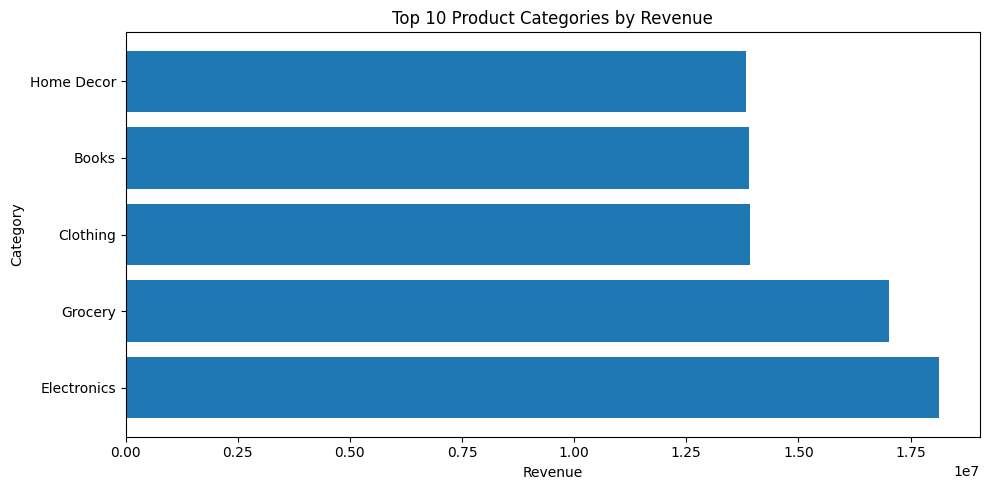

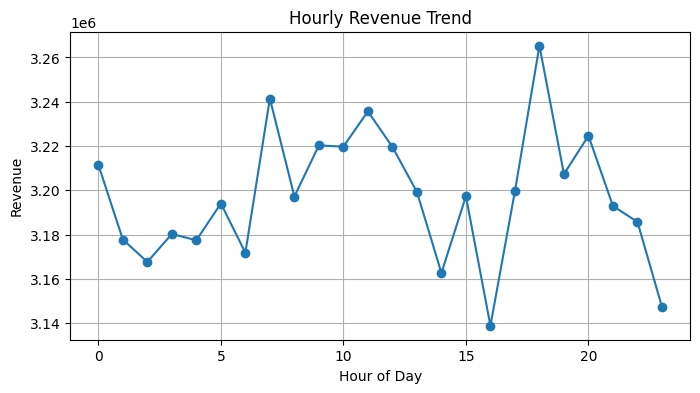

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark -> Pandas for plotting (only small summaries!)
top_products_pd = prod_rev.limit(10).toPandas()
hourly_pd = hourly_sales.toPandas()
payment_pd = pay_method.toPandas()

# Top Product Categories
plt.figure(figsize=(10,5))
plt.barh(top_products_pd['Product_Category'], top_products_pd['total_revenue'])
plt.title('Top 10 Product Categories by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

# Hourly Revenue Trend
plt.figure(figsize=(8,4))
plt.plot(hourly_pd['hour'], hourly_pd['hourly_revenue'], marker='o')
plt.title('Hourly Revenue Trend')
plt.xlabel('Hour of Day')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()




**Predict whether a customer is high spender based on demographics.**

In [29]:
#Fill or drop nulls in numeric columns

from pyspark.sql.functions import col

numeric_cols = ["Age", "Total_Purchases", "Ratings"]
for c in numeric_cols:
    df_ml = df_ml.withColumn(c, col(c).cast("double"))  # ensure numeric type
    df_ml = df_ml.fillna({c: 0})  # replace nulls with 0


In [30]:
#Handle categorical columns with StringIndexer

from pyspark.ml.feature import StringIndexer

# Index Gender (convert string -> numeric)
indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndex", handleInvalid="keep")


In [31]:
#Assemble features safely

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["Age", "GenderIndex", "Total_Purchases", "Ratings"],
    outputCol="features"
)


In [32]:
#Define logistic regression and pipeline

from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import when

# Create label: high-value transaction
percentile = df_ml.approxQuantile("Amount", [0.75], 0.05)[0]
df_ml = df_ml.withColumn("label", when(col("Amount") > percentile, 1).otherwise(0))

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)

pipeline = Pipeline(stages=[indexer, assembler, lr])


In [34]:
# Split data 80/20 for evaluation
train, test = df_ml.sample(False, 0.8, seed=42), df_ml.sample(False, 0.2, seed=42)

# Fit pipeline
model = pipeline.fit(train)
print("✅ Model trained!")


✅ Model trained!


In [35]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Predict on test set
predictions = model.transform(test)

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Model Accuracy: {accuracy*100:.2f}%")

# Evaluate AUC for binary classification
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = binary_evaluator.evaluate(predictions)
print(f"Model AUC: {auc:.2f}")


Model Accuracy: 71.72%
Model AUC: 0.50


In [37]:
from pyspark.sql import Row

# Example: user inputs
user_age = float(input("Enter Age: "))
user_gender = input("Enter Gender (Male/Female): ")
user_total_purchases = float(input("Enter Total Purchases: "))
user_ratings = float(input("Enter Ratings: "))

# Create single-row DataFrame
user_df = spark.createDataFrame([Row(
    Age=user_age,
    Gender=user_gender,
    Total_Purchases=user_total_purchases,
    Ratings=user_ratings,
    Amount=0  # placeholder, label not used for prediction
)])

# Predict
user_pred = model.transform(user_df)
user_pred.select("Age","Gender","Total_Purchases","Ratings","prediction","probability").show(truncate=False)


Enter Age: 22
Enter Gender (Male/Female): Male
Enter Total Purchases: 20000
Enter Ratings: 3.5
+----+------+---------------+-------+----------+-----------------------------------------+
|Age |Gender|Total_Purchases|Ratings|prediction|probability                              |
+----+------+---------------+-------+----------+-----------------------------------------+
|22.0|Male  |20000.0        |3.5    |1.0       |[0.004904003125426676,0.9950959968745733]|
+----+------+---------------+-------+----------+-----------------------------------------+

